In [1]:
import numpy as np
from sklearn.metrics import classification_report


In [2]:
import pandas as pd
from icecream import ic

try:
    wildfire_df = pd.read_csv('../Dataset/inceptionv3.csv')
    ic('Datasets \'inceptionv3.csv\' loaded successfully')
except Exception as e:
    ic(f'Error loading dataset: {e}')

ic| 'Datasets 'inceptionv3.csv' loaded successfully'


In [29]:
print(f'Shape : {wildfire_df.shape}')

print(wildfire_df.info())

Shape : (1800, 2050)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Columns: 2050 entries, feature_1 to label_encoded
dtypes: float64(2048), int64(1), object(1)
memory usage: 28.2+ MB
None


In [5]:
wildfire_df['label'] = wildfire_df['label'].apply(lambda x: x.lower())
print(wildfire_df['label'].unique())

['fire' 'non fire' 'smoke']


In [6]:
wildfire_df['label_encoded'] = wildfire_df['label'].map({
    'non fire': 0,
    'fire': 1,
    'smoke': 2
})

In [7]:
X = wildfire_df.iloc[:,:-2].values
y = wildfire_df['label_encoded'].values

In [8]:
print(wildfire_df['label_encoded'].unique)

<bound method Series.unique of 0       1
1       1
2       1
3       1
4       1
       ..
1795    2
1796    2
1797    2
1798    2
1799    2
Name: label_encoded, Length: 1800, dtype: int64>


### Support Vector Machine (SVM)

In [9]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for GridSearchCV
param_grid= param_grid = [
    {
        'kernel': ['rbf'],
        'C': [0.1, 1, 10, 100],
        'gamma': [0.0001, 0.001, 0.1, 1]
    },
    {
        'kernel': ['poly'],
        'C': [0.1, 1, 10, 100],
        'gamma': [0.0001, 0.001],
        'degree': [2, 3]
    }
]

svc = svm.SVC(probability=True, class_weight='balanced')
model_svm = GridSearchCV(svc,param_grid,cv=5, scoring='f1_macro', refit=True)

In [10]:
# Check y values
print(f'Unique values in y: {np.unique(y)}')

Unique values in y: [0 1 2]


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
import time
start = time.time()
model_svm.fit(X_train_scaled, y_train)
end = time.time()
svm_time = end - start

print("Training time for SVM:", svm_time, "seconds")
print("The best parameter found is : ", model_svm.best_params_)

Training time for SVM: 718.3722348213196 seconds
The best parameter found is :  {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}


### Interpretation

After training the model, we have determined the best combination of parameters. This search identified the radial basis function (RBF) kernel as the most effective. The RBF kernel is particularly well-suited for handling non-linear relationships in the data. The complete training time of the model was approximately 718.372 seconds.


In [13]:
best_svm = model_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test_scaled)
y_proba = best_svm.predict_proba(X_test_scaled)
target_names = ['non fire', 'fire', 'smoke']
print("Classification report for SVM:")
print(classification_report(y_test,y_pred_svm, target_names=target_names))

Classification report for SVM:
              precision    recall  f1-score   support

    non fire       0.94      0.97      0.95       180
        fire       0.98      0.94      0.96       180
       smoke       0.96      0.97      0.96       180

    accuracy                           0.96       540
   macro avg       0.96      0.96      0.96       540
weighted avg       0.96      0.96      0.96       540



### Interpretation

The classification report shows that the SVM performs well accross all classes. Indeed, the precision, recall, and F1-score for each class are all above 0.90. The model is particularly effective in identifying the "smoke" and "fire" classes, with F1-scores of 0.96 each. This indicates that the model very accurately distinguishes between these classes. The "non fire" class has a fairly lower F1-score of 0.95, but it remains very high.

The classes are very well-balanced, which is very beneficial for the model's performance. The overall accuracy of the model is 0.96. The model correctly classifies 96% of the test samples.

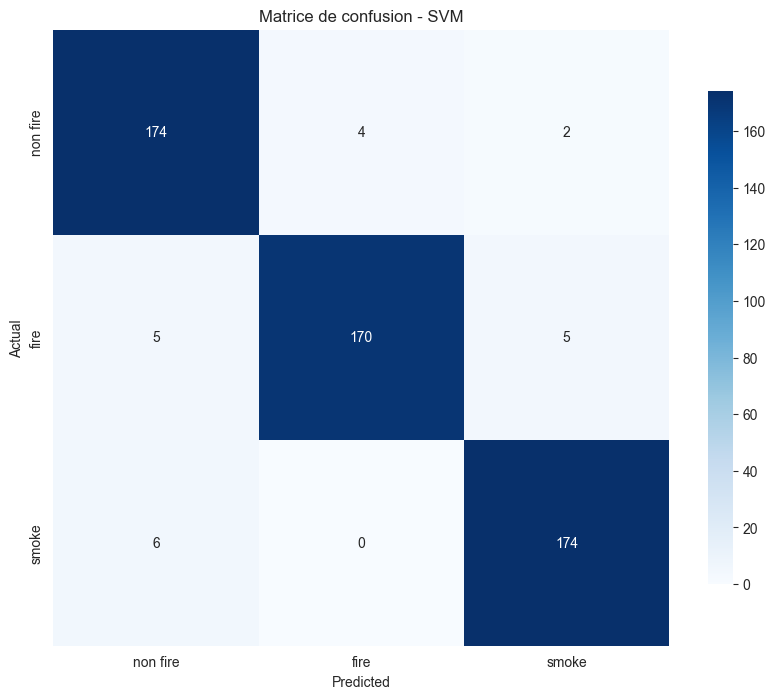

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred_svm)
labels = ['non fire', 'fire', 'smoke']

plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    square=True,
    xticklabels=labels,
    yticklabels=labels,
    cbar_kws={"shrink": .8}
)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matrice de confusion - SVM')
plt.show()


### Interpretation

The confusion matrix presented above illustrates the measurements from the classification report. We can observe that the model predicts the all classes well. Whenever a "fire" image is not correctly classified, it is equally confused for "non fire" and "smoke". In fact, this class produces the most instances of misclassification, with 10 overall. When the actual image corresponds to "smoke", the model classifies it as "non fire" in all cases of the test set. The "nonfire" images are very well classified, with only 6 misclassifications overall, which are mostly confused with "fire".

### K-Nearest Neighbors (KNN)


In [15]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsClassifier()
param_grid = {'n_neighbors': range(1, 21)}

grid_search = GridSearchCV(knn, param_grid, cv=StratifiedKFold(n_splits=5))
grid_search.fit(X_train_scaled, y_train_resampled)

optimal_k = grid_search.best_params_['n_neighbors']
print("Optimal K found:", optimal_k)


/Users/eglantineclervil/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/eglantineclervil/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/eglantineclervil/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Optimal K found: 2


In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report


model_knn = KNeighborsClassifier(n_neighbors=optimal_k)

start = time.time()
model_knn.fit(X_train_scaled, y_train_resampled)
end = time.time()

knn_time = end - start
y_pred_knn = model_knn.predict(X_test_scaled)

print("Training time for KNN:", knn_time, "seconds")
optimal_k = grid_search.best_params_['n_neighbors']
print("Optimal K found:", optimal_k)


Training time for KNN: 0.003253936767578125 seconds
Optimal K found: 2


### Interpretation
After training the KNN model, we found that the optimal number of neighbors is 2. The training time for the model was approximately 0.0033 seconds. This indicates that the KNN model is very efficient in terms of training time, especially when compared to the SVM model.

In [17]:
target_names = ['non fire', 'fire', 'smoke']
print("Classification report for KNN:")
print(classification_report(y_test,y_pred_knn, target_names=target_names))

Classification report for KNN:
              precision    recall  f1-score   support

    non fire       0.94      0.93      0.93       180
        fire       0.95      0.93      0.94       180
       smoke       0.94      0.97      0.96       180

    accuracy                           0.94       540
   macro avg       0.94      0.94      0.94       540
weighted avg       0.94      0.94      0.94       540



### Interpretation
The classification report indicates that the KNN model performs well across all classes. The precision, recall, and F1-score for each class are all above 0.90. The model is particularly effective in identifying the "smoke" class with an F1-Score of 0.96. The "fire" class has a slightly lower F1-score of 0.94, but it remains very high. Finally, the "non fire" class has the lowest F1-score of 0.93, but it is still good. Overall, the model reaches an accuracy score of 0.94, which means that it correctly classifies 94% of the test samples.

### Matrice de confusion pour KNN

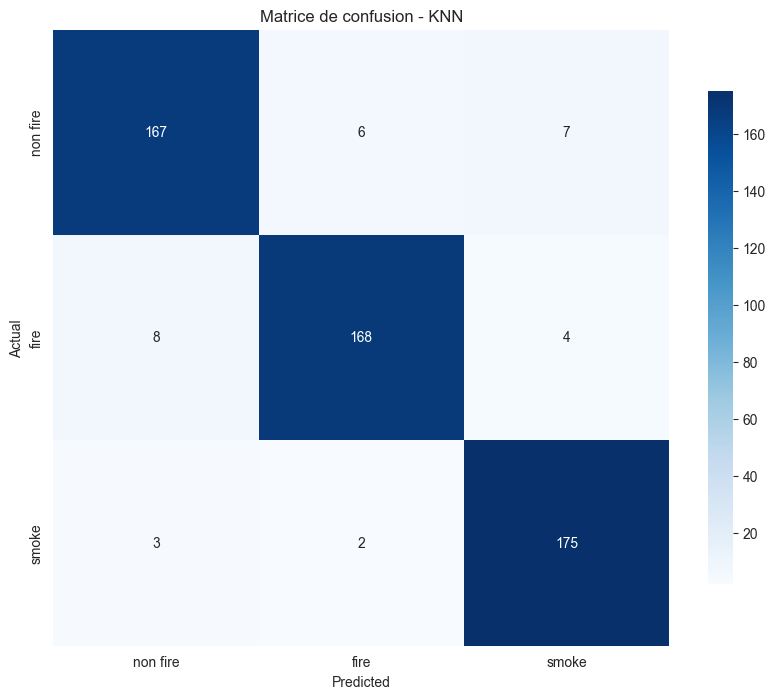

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

matrice_confusion = confusion_matrix(y_test, y_pred_knn)
labels = ['non fire', 'fire', 'smoke']

plt.figure(figsize=(10, 8))
sns.heatmap(
    matrice_confusion,
    annot=True,
    fmt='d',
    cmap='Blues',
    square=True,
    xticklabels=labels,
    yticklabels=labels,
    cbar_kws={"shrink": .8}
)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matrice de confusion - KNN')
plt.show()


### Interpretation
In the cases where an image belonging to the "fire" class is misclassified, it is most often confused with the "non fire" class. This confusion does not occure often, with a total of 8 misclassification of "fire" as "non fire". On the other hand, the "smoke" class is very well classified, with only 5 misclassifications, of which 3 are confused with "non fire", and 2 with "fire". The "non fire" class is mainly misidentified as "smoke", with a total of 7 misclassifications. This class produces the most misclassifications, with a total of 13.

## Decision Tree

In [19]:
from sklearn.tree import DecisionTreeClassifier
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

model_decision_tree = DecisionTreeClassifier()

X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

start = time.time()
model_decision_tree.fit(X_train_resampled, y_train_resampled)
end = time.time()

decision_tree_time = end - start

y_pred_decision_tree = model_decision_tree.predict(X_test)
print("Training time for Decision Tree:", decision_tree_time, "seconds")

/Users/eglantineclervil/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/eglantineclervil/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/eglantineclervil/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Training time for Decision Tree: 1.7598679065704346 seconds


In [20]:
print("Classification report for Decision Tree:")
print(classification_report(y_test,y_pred_decision_tree, target_names=target_names))

Classification report for Decision Tree:
              precision    recall  f1-score   support

    non fire       0.85      0.86      0.86       180
        fire       0.89      0.88      0.89       180
       smoke       0.87      0.87      0.87       180

    accuracy                           0.87       540
   macro avg       0.87      0.87      0.87       540
weighted avg       0.87      0.87      0.87       540



### Interpretation
The classification report indicates that the Decision Tree model performs pretty well across all classes. The "fire" and "smoke" classes have the highest F1-scores of 0.89. The "smoke" class has a slightly lower F1-score of 0.87, but it remains good. Overall, the model reaches an accuracy score of 0.87, which signifies that it correctly categorizes 87% of the test samples. The training time for the Decision Tree model was approximately 1.76 seconds, which is fast compared to the SVM models, but slower than the KNN model.

### Confusion Matrix for Decision Tree


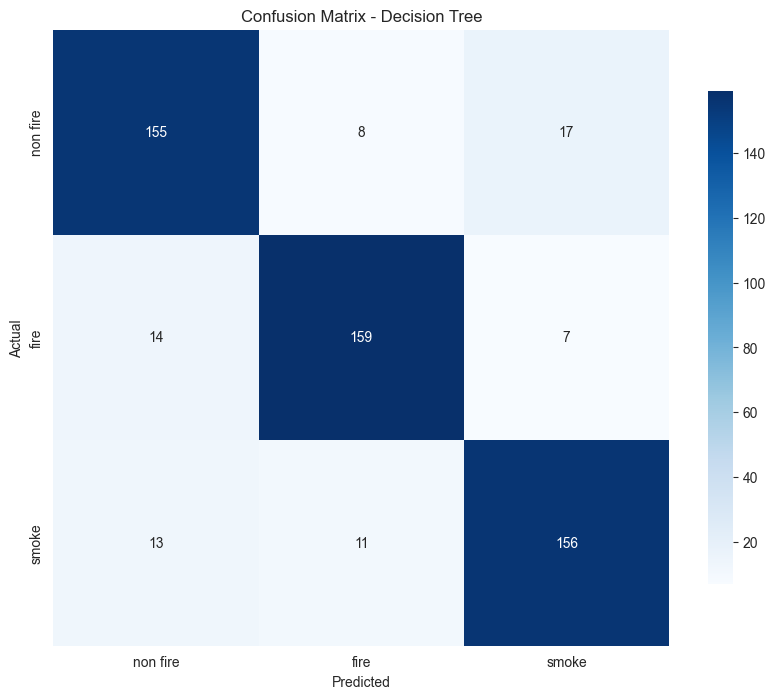

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

confusion_mat = confusion_matrix(y_test, y_pred_decision_tree)

plt.figure(figsize=(10, 8))
sns.heatmap(
    confusion_mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    square=True,
    xticklabels=labels,
    yticklabels=labels,
    cbar_kws={"shrink": .8}
)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix - Decision Tree")
plt.show()


### Interpretation
The confusion matrix shows that the "non fire" class is the least well-classified class, with 25 overall misclassifications. Indeed, it is confused with "fire" 8 times and with "smoke" 17 times. The "smoke" class is slightly better classified, with only 24 misclassifications, of which 11 are confused with "fire" and 13 with "non fire". Finally, the "fire" class is the best classified, with 14 misclassifications, of which most are confused with "non fire". Overall, the Decision Tree model shows poorer performance compared to the SVM and KNN models, particularly in distinguishing between the "non fire" and "smoke" classes.

# Naive Bayes

In [22]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.naive_bayes import GaussianNB
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

naive_bayes = GaussianNB()
start = time.time()
naive_bayes.fit(X_train_scaled, y_train_resampled)
end = time.time()

naive_bayes_time = end - start

y_pred_nb = naive_bayes.predict(X_test_scaled)
print("Training time for Naive Bayes:", naive_bayes_time, "seconds")


Training time for Naive Bayes: 0.029890060424804688 seconds


/Users/eglantineclervil/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/eglantineclervil/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/eglantineclervil/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


In [23]:
print("Classification report for Naive Bayes:")
print(classification_report(y_test,y_pred_nb, target_names=target_names))

Classification report for Naive Bayes:
              precision    recall  f1-score   support

    non fire       0.85      0.84      0.85       180
        fire       0.93      0.94      0.94       180
       smoke       0.86      0.87      0.87       180

    accuracy                           0.88       540
   macro avg       0.88      0.88      0.88       540
weighted avg       0.88      0.88      0.88       540



### Interpretation
The classification report shows that the model is effective in identifying both the "fire" classes, with F1-scores of 0.94 for each. The "smoke" class has a lower F1-score of 0.87, but it remains good. The class "non fire" has the lowest F1-score of 0.85, but it is still acceptable. The Naive Bayes model achieves an accuracy score of 0.88. The training time for the Naive Bayes model was approximately 0.030 seconds, which is fast. Overall, the Naive Bayes model shows a great performance in classifying the different classes in the dataset, with a rapid training time.

### Confusion matrix for Naive Bayes

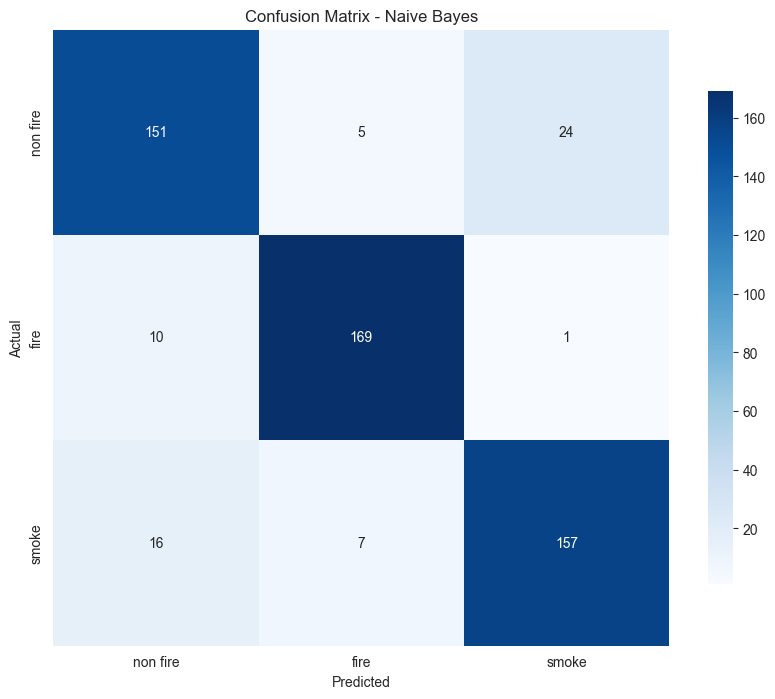

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

confusion_mat = confusion_matrix(y_test, y_pred_nb)
labels = ['non fire', 'fire', 'smoke']

plt.figure(figsize=(10, 8))
sns.heatmap(
    confusion_mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    square=True,
    xticklabels=labels,
    yticklabels=labels,
    cbar_kws={"shrink": .8}
)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Naive Bayes')
plt.show()


### Interpretation
The confusion matrix for the Naive Bayes model shows that the "non fire" class is most often misclasified for "smoke", with a total of 24 misclassifications. It is also confused with "smoke" on five occasions. The "smoke" class is mainly misidentified as "non fire", with a total of 16 misclassifications. Finally, the "fire" class produces the least misclassifications, with a total of 11. In most cases, it is confused with "non fire".

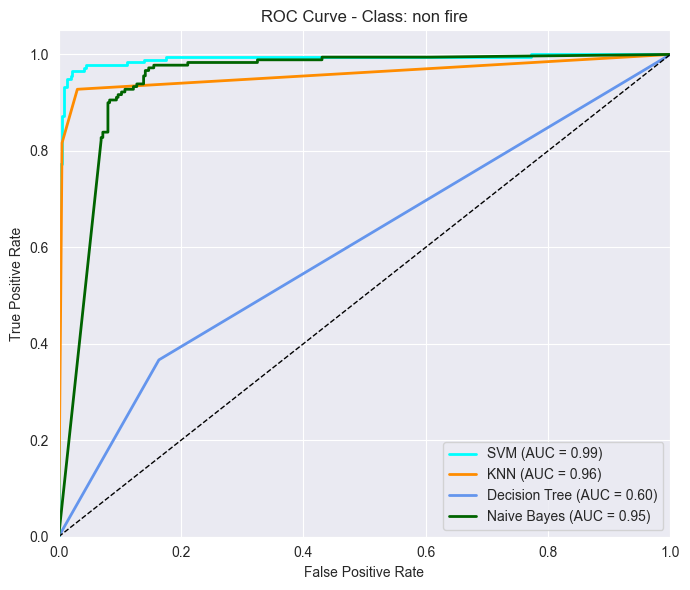

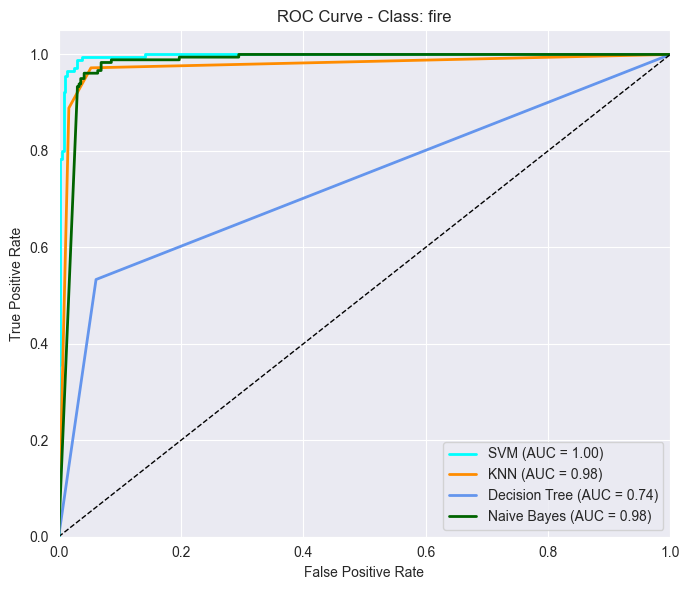

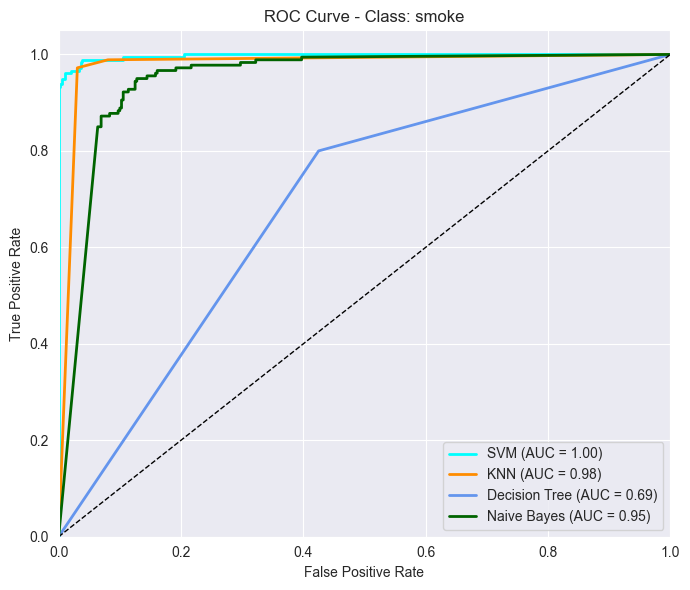

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, classes=list(range(3)))
n_classes = y_test_bin.shape[1]

models = [
    model_svm.best_estimator_,
    model_knn,
    model_decision_tree,
    naive_bayes
]

model_names = ['SVM', 'KNN', 'Decision Tree', 'Naive Bayes']
colors = ['aqua', 'darkorange', 'cornflowerblue', 'darkgreen']

labels = {
    0 : 'non fire',
    1 : 'fire',
    2 : 'smoke'
}


for class_idx in range(n_classes):
    plt.figure(figsize=(7, 6))

    for model, name, color in zip(models, model_names, colors):
        y_score = model.predict_proba(X_test_scaled)

        fpr, tpr, _ = roc_curve(y_test_bin[:, class_idx], y_score[:, class_idx])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, color=color, lw=2,
                 label=f'{name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Class: {labels[class_idx]}')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()


### Interpretation

The ROC curves for each class show that the SVM model consistently outperforms the other models across all classes (approximately AUC score of 1 accr0ss all classes). This high score indicates that the SVM is the most effective model for distinguishing between the different classes. Decision Tree models show the lowest performance, particularly for the "non fire" class, where it has an AUC score of around 0.60. This score indicates that Decision Trees struggles to differentiate between the classes effectively. The value of AUC remains the lowest across all classes.

# Graphical comparison of models

           Model  Accuracy  F1 Score       AUC    Recall
0            SVM  0.959259  0.959289  0.994614  0.959289
1            KNN  0.944444  0.944355  0.970602  0.944444
2  Decision Tree  0.870370  0.870429  0.902778  0.870370
3    Naive Bayes  0.883333  0.883210  0.958061  0.883333


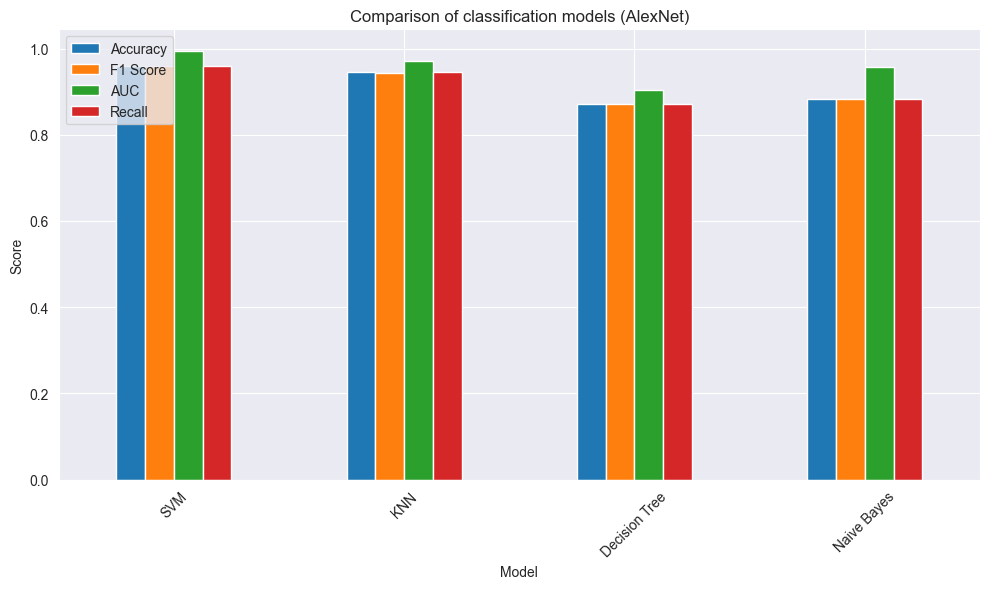

In [26]:
from sklearn.metrics import roc_auc_score
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

results = pd.DataFrame({
    'Model': ['SVM', 'KNN', 'Decision Tree', 'Naive Bayes'],
    'Accuracy': [
        accuracy_score(y_test, model_svm.predict(X_test_scaled)),
        accuracy_score(y_test, model_knn.predict(X_test_scaled)),
        accuracy_score(y_test, model_decision_tree.predict(X_test)),
        accuracy_score(y_test, naive_bayes.predict(X_test_scaled))
    ],
    'F1 Score': [
        f1_score(y_test, model_svm.predict(X_test_scaled), average='weighted'),
        f1_score(y_test, model_knn.predict(X_test_scaled), average='weighted'),
        f1_score(y_test, model_decision_tree.predict(X_test), average='weighted'),
        f1_score(y_test, naive_bayes.predict(X_test_scaled), average='weighted')
    ],
    'AUC': [
        roc_auc_score(y_test, model_svm.predict_proba(X_test_scaled), multi_class='ovr'),
        roc_auc_score(y_test, model_knn.predict_proba(X_test_scaled), multi_class='ovr'),
        roc_auc_score(y_test, model_decision_tree.predict_proba(X_test), multi_class='ovr'),
        roc_auc_score(y_test, naive_bayes.predict_proba(X_test_scaled), multi_class='ovr')
    ],
    'Recall': [
        model_svm.score(X_test_scaled, y_test),
        model_knn.score(X_test_scaled, y_test),
        model_decision_tree.score(X_test, y_test),
        naive_bayes.score(X_test_scaled, y_test)
    ],
})


print(results)
plt.figure(figsize=(10, 6))
results.plot(kind='bar', x='Model', y=['Accuracy', 'F1 Score', 'AUC', 'Recall'], rot=0, ax=plt.gca())
plt.title('Comparison of classification models (InceptionV3)')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()



### Interpretation
SVM seems to be the most reliable and balanced model here, with KNN as a decent alternative. Decision Tree is the least effective model, with lower scores across all metrics. Naive Bayes performs reasonably well, but is outperformed by SVM and KNN in most metrics.


           Model  Training Time
0            SVM     718.372235
1            KNN       0.003254
2  Decision Tree       1.759868
3    Naive Bayes       0.029890


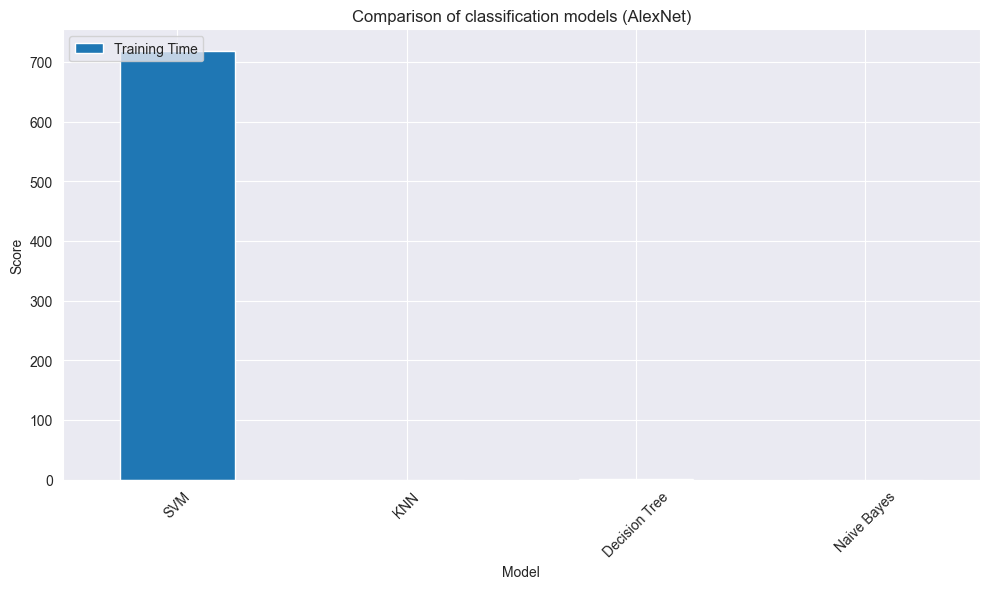

In [27]:
import matplotlib.pyplot as plt
training_times = {
    'Model': ['SVM', 'KNN', 'Decision Tree', 'Naive Bayes'],
    'Training Time': [svm_time, knn_time, decision_tree_time, naive_bayes_time]
}
results = pd.DataFrame(training_times)
print(results)

plt.figure(figsize=(10, 6))
results.plot(kind='bar', x='Model', y='Training Time', ax=plt.gca())
plt.title('Comparison of classification models (InceptionV3)')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


         Model  Training Time
0          KNN       0.003254
1  Naive Bayes       0.029890


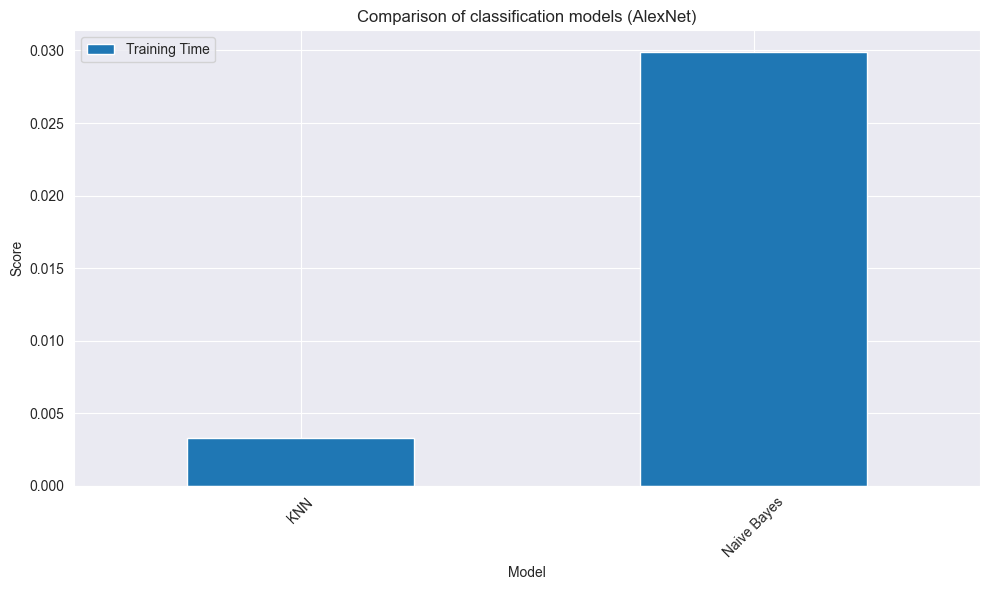

In [28]:
import matplotlib.pyplot as plt
training_times_2 = {
    'Model': ['KNN', 'Naive Bayes'],
    'Training Time': [knn_time, naive_bayes_time]
}
results = pd.DataFrame(training_times_2)
print(results)

plt.figure(figsize=(10, 6))
results.plot(kind='bar', x='Model', y='Training Time', ax=plt.gca())
plt.title('Comparison of classification models (InceptionV3)')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


### Interpretation
The training time comparison shows that the KNN and Naive Bayes models are significantly faster to train compared to the SVM and Decision Tree models. KNN has a training time of approximately 0.0066 seconds, while Naive Bayes is even faster at around 0.003254 seconds. In contrast, the SVM model takes about 718.372 seconds to train, and the Decision Tree model takes around 1.76 seconds. This indicates that KNN and Naive Bayes are more efficient in terms of training time.

In summary, while SVM offers the best performance, it comes with a high training time cost. KNN and Naive Bayes provide a good balance between performance and training time, with KNN being slightly more accurate and faster than Naive Bayes.